In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ - Criar a máscara binária
# ==========================
def create_binary_mask_(img, threshold_value=100, bin_method="global"):
    """
    Cria uma máscara binária a partir de uma imagem colorida.
    Parâmetros:
        bin_method: 'global', 'otsu' ou 'adaptive'
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if bin_method == "global":
        _, mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    elif bin_method == "otsu":
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif bin_method == "adaptive":
        mask = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, blockSize=11, C=2
        )
    else:
        raise ValueError("bin_method deve ser 'global', 'otsu' ou 'adaptive'")
    return mask


# ==========================
# 2️⃣ - Fechamento morfológico
# ==========================
def morphological_closing_(mask, kernel_size=5):
    """
    Aplica fechamento morfológico para preencher falhas e unir áreas próximas.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed


# ==========================
# 3️⃣ - Limpeza da imagem
# ==========================
def remove_background_(img, mask, invert_mask=True):
    """
    Remove o fundo da imagem aplicando a máscara.
    """
    if invert_mask:
        mask = cv2.bitwise_not(mask)
    cleaned = cv2.bitwise_and(img, img, mask=mask)
    return cleaned


# ==========================
# 4️⃣ - Transformada de Hough
# ==========================
def detect_circles_(img, dp=1.2, minDist=20, param1=100, param2=30, minRadius=5, maxRadius=50):
    """
    Detecta círculos usando a Transformada de Hough.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp, minDist,
        param1=param1, param2=param2,
        minRadius=minRadius, maxRadius=maxRadius
    )
    output = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
            cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
    return output, circles


# ==========================
# 5️⃣ - Pipeline completa
# ==========================
def full_hough_pipeline_(
    image_path,
    bin_method="global",
    threshold_value=100,
    kernel_size=5,
    invert_mask=True,
    dp=1.2, minDist=15,
    param1=100, param2=30,
    minRadius=5, maxRadius=50
):
    """
    Executa o pipeline completo de segmentação e detecção.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Não foi possível carregar a imagem: {image_path}")

    mask = create_binary_mask_(img, threshold_value, bin_method)
    closed = morphological_closing_(mask, kernel_size)
    cleaned = remove_background_(img, closed, invert_mask)
    detected, circles = detect_circles_(cleaned, dp, minDist, param1, param2, minRadius, maxRadius)

    return {
        "img": img,
        "mask": mask,
        "closed_mask": closed,
        "cleaned": cleaned,
        "detected": detected,
        "circles": circles
    }


# ==========================
# 6️⃣ - Visualização dos resultados
# ==========================
def plot_pipeline_results(results, figsize=(20,6)):
    """
    Exibe as principais etapas da pipeline.
    """
    fig, axs = plt.subplots(1, 5, figsize=figsize)

    axs[0].imshow(cv2.cvtColor(results["img"], cv2.COLOR_BGR2RGB))
    axs[0].set_title("Imagem original")
    axs[0].axis("off")

    axs[1].imshow(results["mask"], cmap='gray')
    axs[1].set_title("Máscara binária")
    axs[1].axis("off")

    axs[2].imshow(results["closed_mask"], cmap='gray')
    axs[2].set_title("Fechamento morfológico")
    axs[2].axis("off")

    axs[3].imshow(cv2.cvtColor(results["cleaned"], cv2.COLOR_BGR2RGB))
    axs[3].set_title("Imagem sem fundo")
    axs[3].axis("off")

    axs[4].imshow(cv2.cvtColor(results["detected"], cv2.COLOR_BGR2RGB))
    axs[4].set_title("Detecção por Hough")
    axs[4].axis("off")

    plt.tight_layout()
    plt.show()


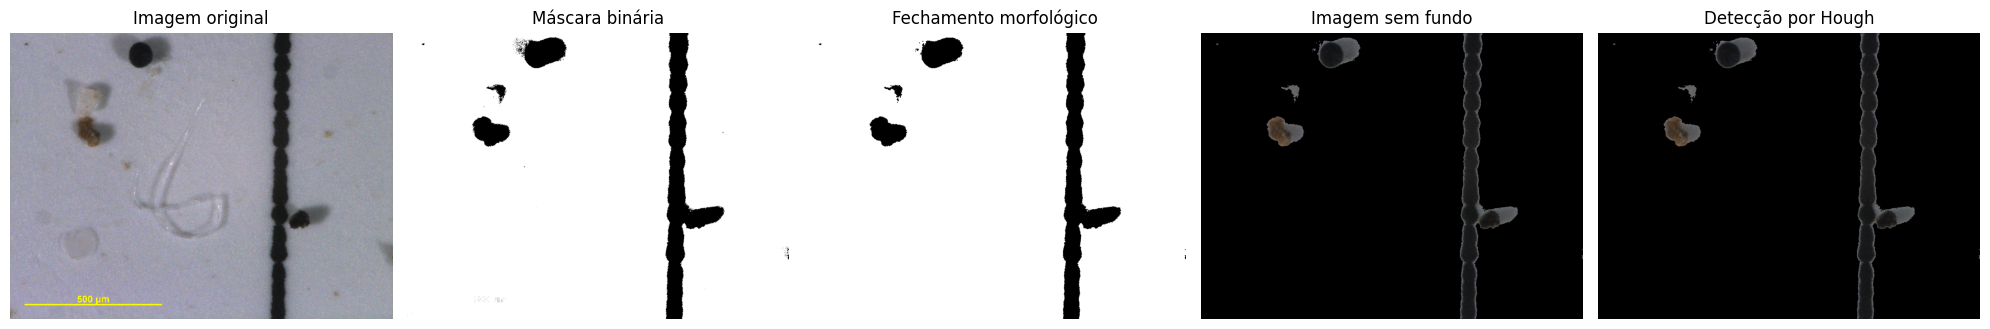

Circles: None


In [31]:
# Carrega a imagem
path = r"..\data\CNN_P1_L1_T1_M1_LC_Q9_100x.jpg"

results = full_hough_pipeline_(
    path,
    bin_method="global",      # "global", "otsu" ou "adaptive"
    threshold_value=110,        # só usado para 'global'
    kernel_size=5,
    invert_mask=True,
    dp=1.2, minDist=15,
    param1=100, param2=25,
    minRadius=3, maxRadius=60
)
plot_pipeline_results(results)
print("Circles:", results["circles"])


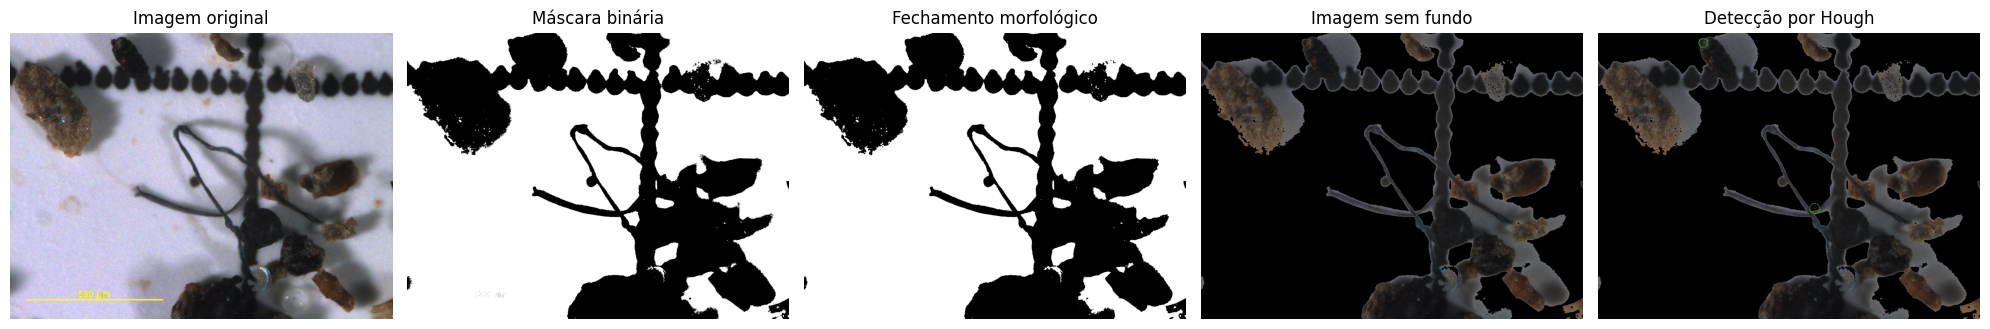

Circles: [[[1466 1190   34]
  [ 711   73   30]]]


In [30]:
path = r"..\data\CNN_P1_L1_T1_M1_LG_Q11_100x.jpg"

results = full_hough_pipeline_(
    path,
    bin_method="global",      # "global", "otsu" ou "adaptive"
    threshold_value=110,        # só usado para 'global'
    kernel_size=5,
    invert_mask=True,
    dp=1.2, minDist=15,
    param1=100, param2=25,
    minRadius=3, maxRadius=60
)
plot_pipeline_results(results)
print("Circles:", results["circles"])

# Tentativa de Remoção

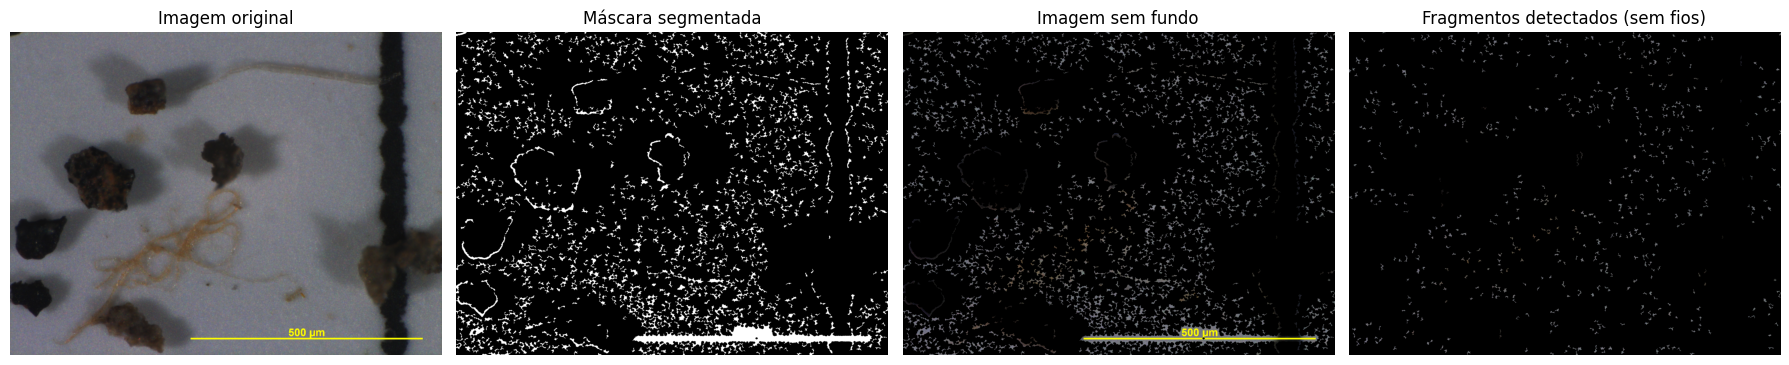

In [26]:
import cv2
import numpy as np
from skimage import measure, feature, morphology, color
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ======================================================
# 1. Pré-processamento e segmentação de partículas
# ======================================================

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def remove_background(img):
    # Conversão para HSV e threshold adaptativo
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    blur = cv2.GaussianBlur(v_channel, (5,5), 0)
    mask = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 35, 5)
    
    # Fechamento morfológico para preencher buracos
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Remoção de ruído pequeno
    mask_clean = morphology.remove_small_objects(mask_closed.astype(bool), 100)
    mask_clean = mask_clean.astype(np.uint8) * 255
    
    # Aplica a máscara no RGB
    result = cv2.bitwise_and(img, img, mask=mask_clean)
    return result, mask_clean

# ======================================================
# 2. Extração de características de forma e textura
# ======================================================

def extract_features(mask, img):
    # Label dos objetos detectados
    labels = measure.label(mask, connectivity=2)
    props = measure.regionprops(labels, intensity_image=color.rgb2gray(img))
    
    features = []
    for p in props:
        if p.area < 80:  # ignora ruídos
            continue
        
        gray_patch = p.intensity_image
        gray_patch = gray_patch / gray_patch.max() if gray_patch.max() > 0 else gray_patch
        
        # Haralick (textura)
        glcm = feature.graycomatrix((gray_patch * 255).astype(np.uint8),
                                    distances=[2], angles=[0], levels=256,
                                    symmetric=True, normed=True)
        contrast = feature.graycoprops(glcm, 'contrast')[0,0]
        homogeneity = feature.graycoprops(glcm, 'homogeneity')[0,0]
        energy = feature.graycoprops(glcm, 'energy')[0,0]
        
        # Forma
        circularity = 4 * np.pi * p.area / (p.perimeter ** 2 + 1e-5)
        aspect_ratio = p.major_axis_length / (p.minor_axis_length + 1e-5)
        
        features.append([p.area, contrast, homogeneity, energy, circularity, aspect_ratio])
    
    return np.array(features), labels

# ======================================================
# 3. Clusterização e visualização
# ======================================================

def classify_particles(features, labels, img):
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    preds = kmeans.fit_predict(features)
    
    # Define qual cluster corresponde aos "fragmentos"
    # Heurística: fragmentos tendem a ser mais circulares e menos alongados
    frag_cluster = np.argmin([np.mean(features[preds==i,5]) for i in range(2)])
    
    mask_fragments = np.zeros(labels.shape, dtype=np.uint8)
    for i, region_label in enumerate(np.unique(labels)):
        if region_label == 0:  # fundo
            continue
        if preds[i-1] == frag_cluster:
            mask_fragments[labels == region_label] = 255
    
    img_fragments = cv2.bitwise_and(img, img, mask=mask_fragments)
    return mask_fragments, img_fragments

# ======================================================
# 4. Pipeline completa
# ======================================================

def run_pipeline(image_path):
    img = preprocess_image(image_path)
    result, mask = remove_background(img)
    features, labels = extract_features(mask, img)
    mask_frag, img_frag = classify_particles(features, labels, img)
    
    # Visualização
    fig, axs = plt.subplots(1, 4, figsize=(18,6))
    axs[0].imshow(img)
    axs[0].set_title("Imagem original")
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Máscara segmentada")
    axs[2].imshow(result)
    axs[2].set_title("Imagem sem fundo")
    axs[3].imshow(img_frag)
    axs[3].set_title("Fragmentos detectados (sem fios)")
    for a in axs: a.axis('off')
    plt.tight_layout()
    plt.show()

# ======================================================
# Execução
# ======================================================

run_pipeline(r"..\data\CNN_P1_L1_T1_M1_LG_Q8_150x.jpg")
